# TSP using a heuristic solver: Simulated Annealing


In [1]:
!pip install python_tsp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 90.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 42.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Uninstalling numpy-1.23.4:
      Successfully uninstalled numpy-1.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.3 requires numpy<1.26.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.


In [2]:
import numpy as np
import math
from python_tsp.exact import solve_tsp_dynamic_programming
from itertools import permutations
import copy


In [3]:
distance_matrix = np.array([
    [0,  5, 4, 10, 6, 9 ],
    [5,  0, 8,  5, 3, 11],
    [4,  8, 0,  3, 2, 4 ],
    [10, 5, 3,  0, 8, 7 ],
    [6,  3, 2,  8, 0, 8 ],
    [9, 11, 4,  7, 8, 0 ]
])


In [4]:
def n_cities(distance_matrix):
    " number of cities in a distance_matrix"
    assert distance_matrix.shape[0] == distance_matrix.shape[1]
    return distance_matrix.shape[0]

In [5]:
n_cities(distance_matrix)

6

In [6]:
def cities(distance_matrix):
    " list with city numbers in a tsp distance_matrix"
    return list(range(0,n_cities(distance_matrix)))

In [7]:
cities(distance_matrix)

[0, 1, 2, 3, 4, 5]

In [8]:
def cost_function(path, distance_matrix):
    "cost function for a TSP problem instance given as a distrance matrix"
    cost=0
    for i in range(len(path)-1):
        cost = cost + distance_matrix[path[i],path[i+1]]
    cost = cost + distance_matrix[path[-1],path[0]]
    return cost

In [9]:
def solve_tsp_brute_force(distance_matrix):
    "a brute force implementation of TSP"
    steps=0
    best_path = None
    for alternative in permutations(cities(distance_matrix)):
        steps = steps +1
        if best_path is None or cost_function(best_path, distance_matrix ) > cost_function(alternative, distance_matrix):
            best_path = list(alternative)
    return best_path, cost_function(best_path, distance_matrix), steps


In [10]:
def cycle(path):
    "make a cyclic path"
    return path+path[0:1]

In [11]:
path, distance,steps = solve_tsp_brute_force(distance_matrix)
print(cycle(path), distance)
print("Steps", steps, " (n!)")

[0, 1, 3, 5, 2, 4, 0] 29
Steps 720  (n!)


In [12]:
# Use the dynamic programming solver provided by python-tsp
path, distance = solve_tsp_dynamic_programming(distance_matrix)
print(cycle(path), distance)
n=n_cities(distance_matrix)
print("Steps", n**2*2**n , " (n^2*2^n)")

[0, 1, 3, 5, 2, 4, 0] 29
Steps 2304  (n^2*2^n)


In [13]:
def tsp_random(distance_matrix, budget):
    "global random search for TSP"
    best_path=None

    for trials in range(budget):

        # move: global random search
        alternative=list(np.random.permutation(cities(distance_matrix)))

        if best_path is None or cost_function(best_path, distance_matrix ) > cost_function(alternative, distance_matrix):
            best_path = alternative

    return best_path, cost_function(best_path, distance_matrix)

In [14]:
tsp_random(distance_matrix, 100)

([2, 3, 5, 0, 1, 4], 29)

In [15]:
def tsp_hilldescent(distance_matrix, budget):
    "local hill descent for TSP"

    # initial solution
    best_path=list(np.random.permutation(cities(distance_matrix)))

    for trials in range(budget):

        if np.random.random()<0.9:
            # move: local search
            alternative = select_neighbourgh(best_path)
        else:
            # move: global random search
            alternative=list(np.random.permutation(cities(distance_matrix)))

        if cost_function(best_path, distance_matrix ) > cost_function(alternative, distance_matrix):
            best_path = alternative

    return best_path, cost_function(best_path, distance_matrix)

In [16]:
def select_neighbourgh(path):
    "return a new path where two cities are swapped randomly."

    i = np.random.randint(0,len(path))
    j=i
    while j==i:
        j = np.random.randint(0,len(path))
    path = copy.copy(path)
    path[i],path[j] = path[j], path[i]

    return path

In [17]:
tsp_hilldescent(distance_matrix,25)

([1, 0, 5, 3, 2, 4], 29)

In [18]:
from python_tsp.distances import euclidean_distance_matrix

In [19]:
import matplotlib.pyplot as plt

def plotTSP(paths, points, num_iters=1, budget=None, cost=None):
    """
    Show a TSP problem instance and its solution

    paths: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list

    source: https://gist.github.com/payoung/6087046
    """

    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = 'r',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(0, max(x)*1.1)
    plt.ylim(0, max(y)*1.1)
    if budget and cost:
        plt.title("TSP budget %d best solution cost %.2f" % (budget, cost))
    elif cost:
        plt.title("TSP best solution cost %.2f" % (cost))
    plt.show()

In [20]:
N=100 # number of cities
city_locations = np.random.uniform(0,100, (N,2)) # x,y coordinates each city

In [21]:
print("Steps brute force", math.factorial(N))
print("Steps dynamic programming",  N**2 * 2**N )

Steps brute force 93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000
Steps dynamic programming 12676506002282294014967032053760000


In [22]:
def run_tsp(algorithm, city_locations, budget =None, plot= True):
    distance_matrix = euclidean_distance_matrix(city_locations)
    if budget:
        path, _ = algorithm(distance_matrix,budget)
    else:
        path, _ = algorithm(distance_matrix)
    cost = cost_function(path, distance_matrix)
    if plot:
        plotTSP([path],city_locations,budget=budget,cost=cost)
    return cost

In [23]:
# run_tsp(solve_tsp_dynamic_programming, city_locations)

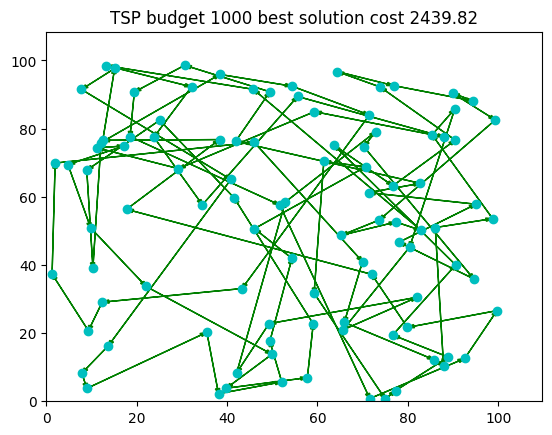

2439.8163520696853

In [24]:
run_tsp(tsp_hilldescent, city_locations, budget= 1000)

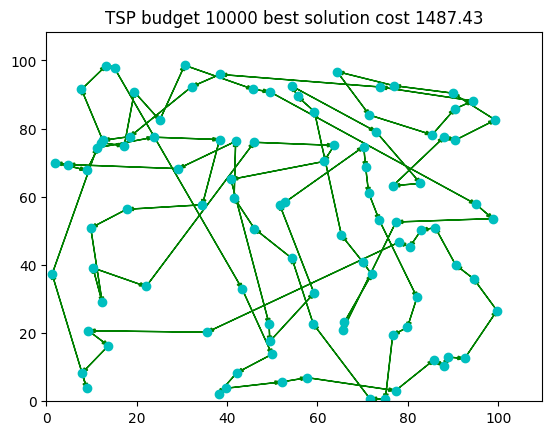

1487.4314069896225

In [25]:
run_tsp(tsp_hilldescent, city_locations, budget= 10000)

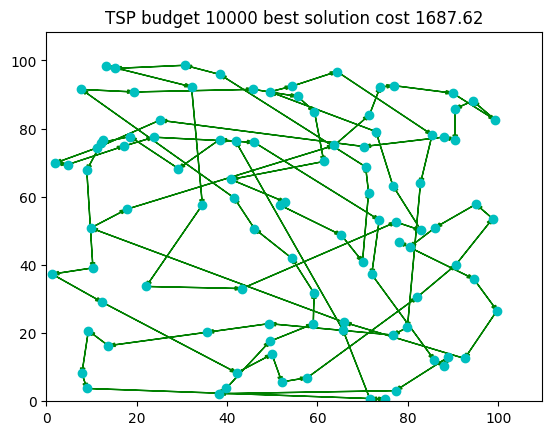

1687.6152623138516

In [26]:
run_tsp(tsp_hilldescent,city_locations,budget= 10000)

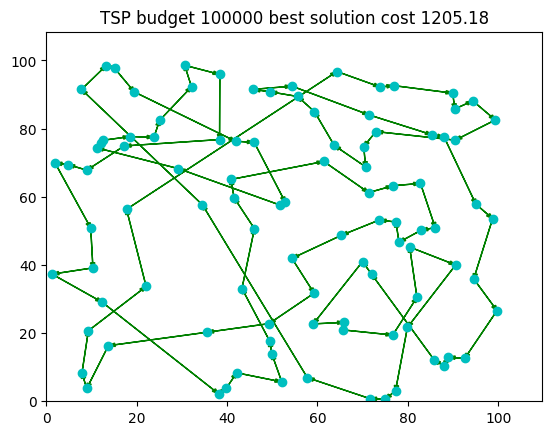

1205.1767076089573

In [27]:
run_tsp(tsp_hilldescent, city_locations, budget= 100000)

## Simulated Annealing for TSP

In [32]:
def city_transport(path):
    "return a new path where two cities are swapped randomly."

    i = np.random.randint(0,len(path))
    j=i
    while j==i:
        j = np.random.randint(0,len(path))
    path = copy.copy(path)
    path[i],path[j] = path[j], path[i]

    return path

def tsp_2_opt(path):
    "return a new path where a segment is reverersed."

    i = np.random.randint(0,len(path)-1)
    j = np.random.randint(i+1,len(path))
     
    reversed= path[i:j]
    reversed.reverse()
    
    result=path[:i]+reversed+path[j:]
    
    return result

#tsp_sa_transform = city_transport
tsp_sa_transform  = tsp_2_opt

In [41]:
def tsp_sa(distance_matrix, budget):
    "Simulated Annealing for TSP"

    # initial solution
    best_solution=list(np.random.permutation(cities(distance_matrix)))
    E= cost_function(best_solution, distance_matrix )
    
    current_solution= best_solution
    
    T= 1
    alpha = 0.95 # 0.95 .. 0.99
    
    N_TI= n_cities(distance_matrix) * 100
    N_AI = budget // N_TI
    
    for ai in range(N_AI):     # Annealing iterations
        for ti in range(N_TI): # Temperature iterations
            
            alternative = tsp_sa_transform(current_solution)
            deltaE = cost_function(alternative, distance_matrix) - E
            
            if deltaE < 0 or np.random.rand() < math.exp( - deltaE / T):
                current_solution = alternative
                
            if deltaE < 0:
                best_solution = current_solution
                E = cost_function(best_solution, distance_matrix )
                    
        T= alpha * T

    return best_solution, E

In [ ]:
def tsp_sa_alt(distance_matrix):
    "Simulated Annealing for TSP"

    # initial solution
    best_solution=list(np.random.permutation(cities(distance_matrix)))
    E= cost_function(best_solution, distance_matrix )
    
    previousE=E
    did_not_improve =0
    
    current_solution= best_solution
    
    T= 1
    alpha = 0.90 # 0.95 .. 0.99
    
    N= n_cities(distance_matrix)
    N_TI= N * 100
    
    
    while did_not_improve<3:
        elementary_transformations = 0
        steps=1 
        while  elementary_transformations / steps < 12 / 100: # Temperature iterations
            steps=steps +1 
            alternative = tsp_sa_transform(current_solution)
            deltaE = cost_function(alternative, distance_matrix) - E
            
            if deltaE < 0:
                elementary_transformations = elementary_transformations +1
                current_solution = alternative
            elif np.random.rand() < math.exp( - deltaE / T):
                current_solution = alternative
            if deltaE < 0:
                best_solution = current_solution
                E = cost_function(best_solution, distance_matrix )
            
            if previousE == E:
                did_not_improve = did_not_improve +1
                if did_not_improve>3:
                    break
            else:
                did_not_improve =0
                peviousE = E

                    
        print( elementary_transformations / steps, 12/100)
           
        T= alpha * T
        
    
    return best_solution, E

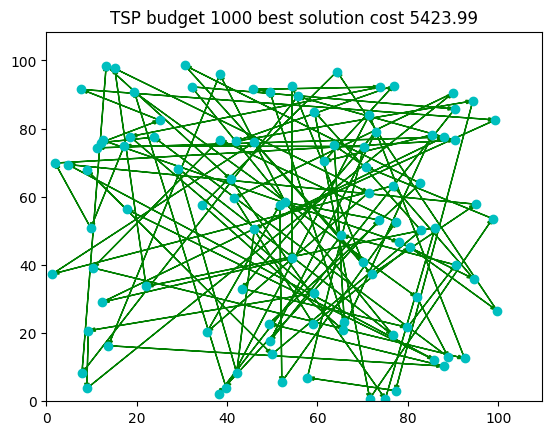

5423.990941899483

In [61]:
run_tsp(tsp_sa, city_locations, budget=1000)

In [ ]:
run_tsp(tsp_sa_alt, city_locations)

0.5 0.12
0.5 0.12
0.3333333333333333 0.12
0.5 0.12
0.5 0.12
0.5 0.12
0.14285714285714285 0.12
0.3333333333333333 0.12
0.25 0.12
0.3333333333333333 0.12
0.14285714285714285 0.12
0.5 0.12
0.3333333333333333 0.12
0.16666666666666666 0.12
0.3333333333333333 0.12
0.3333333333333333 0.12
0.5 0.12
0.3333333333333333 0.12
0.25 0.12
0.5 0.12
0.125 0.12
0.25 0.12
0.5 0.12
0.3333333333333333 0.12
0.5 0.12
0.25 0.12
0.2 0.12
0.3333333333333333 0.12
0.5 0.12
0.5 0.12
0.5 0.12
0.5 0.12
0.5 0.12
0.16666666666666666 0.12
0.5 0.12
0.3333333333333333 0.12
0.16666666666666666 0.12
0.25 0.12
0.25 0.12
0.5 0.12
0.5 0.12
0.5 0.12
0.25 0.12
0.5 0.12
0.5 0.12
0.2 0.12
0.5 0.12
0.2 0.12
0.25 0.12
0.2 0.12
0.25 0.12
0.5 0.12
0.3333333333333333 0.12
0.2 0.12
0.5 0.12
0.2 0.12
0.5 0.12
0.2 0.12
0.15384615384615385 0.12
0.5 0.12
0.5 0.12
0.125 0.12
0.25 0.12
0.5 0.12
0.3333333333333333 0.12
0.2 0.12
0.16666666666666666 0.12
0.14285714285714285 0.12
0.25 0.12
0.16666666666666666 0.12
0.3333333333333333 0.12
0.125 0

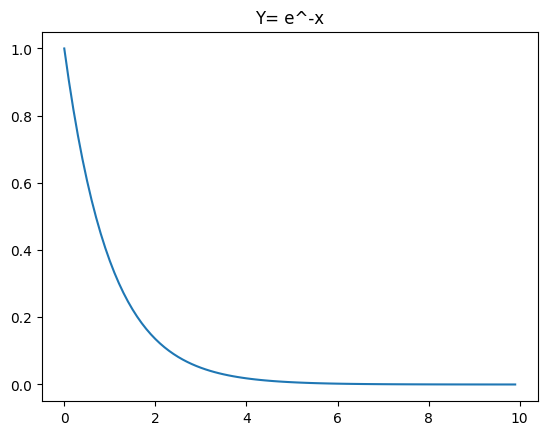

In [38]:
X = np.arange(0, 10, .1)
Y = np.exp(-X)
 
plt.plot(X, Y)
plt.title("Y= e^-x")
plt.show()